In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rrcf
from rrcf.shingle import shingle

data = np.load("taxi_all.npz")

parmas = {"trees"      : 100,
         "sample_size" : 1000,
         "data_dim"    : 48}

# Anamolies from the paper
time_stamps = [np.datetime64(i) for i in data["dates"]]

independence_day = (time_stamps.index(np.datetime64('2014-07-04 00:00:00')),
                    time_stamps.index(np.datetime64('2014-07-07 00:00:00')))
labor_day        = (time_stamps.index(np.datetime64('2014-09-01 00:00:00')),
                    time_stamps.index(np.datetime64('2014-09-02 00:00:00')))
labor_day_parade = (time_stamps.index(np.datetime64('2014-09-06 00:00:00')),
                    time_stamps.index(np.datetime64('2014-09-07 00:00:00')))
NYC_marathon     = (time_stamps.index(np.datetime64('2014-11-02 00:00:00')),
                    time_stamps.index(np.datetime64('2014-11-03 00:00:00')))
thanksgiving     = (time_stamps.index(np.datetime64('2014-11-27 00:00:00')),
                    time_stamps.index(np.datetime64('2014-11-28 00:00:00')))
christmas        = (time_stamps.index(np.datetime64('2014-12-25 00:00:00')),
                    time_stamps.index(np.datetime64('2014-12-26 00:00:00')))
new_year         = (time_stamps.index(np.datetime64('2015-01-01 00:00:00')),
                    time_stamps.index(np.datetime64('2015-01-02 00:00:00')))
blizzard         = (time_stamps.index(np.datetime64('2015-01-26 00:00:00')),
                    time_stamps.index(np.datetime64('2015-01-28 00:00:00')))
anamolies = [independence_day, labor_day, labor_day_parade, NYC_marathon, thanksgiving, christmas, new_year, blizzard]

labels = np.ones(len(data["passengers"]))

for i,j in anamolies:
    labels[i:j] = -1

# Make the data numpy friedly 
DATA = {"timestamp" : np.asarray(time_stamps),
        "passengers": data["passengers"],
        "labels"    : labels}

# Sampling
class sampling:
    def __init__(self, sample_size, sampling_type):
        self.memory = [] # remember the indx of the data inserted into tree
        self.sample_type = sampling_type
        self.sample_size = sample_size
        
    def update_sample(self, data_point_indx):
        indx_forget_point = []
        insert_point = False
        
        if self.sample_type == "replay_memory":
            
            if len(self.memory) >= self.sample_size:
                indx_forget_point.append(self.memory[0])
                self.memory.pop(0)
                self.memory.append(data_point_indx)
            else:
                self.memory.append(data_point_indx)
            
            insert_point = True
            return insert_point, indx_forget_point
        
        elif self.sample_type == "resorvior":
            
            if len(self.memory) >= self.sample_size:
                if np.random.rand() <= self.sample_size/(self.sample_size + 1):
                    # forget a random point in the past
                    random_forget = np.random.choice(len(self.memory))
                    indx_forget_point.append(self.memory[random_forget])
                    self.memory.pop(random_forget)
                    insert_point = True 
                    self.memory.append(data_point_indx)
                else:
                    insert_point = False
            else:
                insert_point = True 
                self.memory.append(data_point_indx)
            return insert_point, indx_forget_point
         
        else:
            # Do nothing
            return insert_point, indx_forget_point

In [2]:
# make the inital trees 
data_stream = shingle(data["passengers"], parmas["data_dim"])
inital_data = next(data_stream)
inital_data = np.vstack((inital_data, next(data_stream)))
inital_data = np.vstack((inital_data, next(data_stream)))
# add 3 data points 

# rabom forest
forest = [rrcf.RCTree(inital_data) for i in range(0, parmas["trees"])]
sample = sampling( parmas["data_dim"] , "replay_memory")
sample.memory.append(0)
sample.memory.append(1)
sample.memory.append(2)

codisp = np.zeros((len(data["passengers"]), parmas["trees"]))
for i in range(3*parmas["data_dim"], len(data["passengers"])):

    insert_point, forget_point = sample.update_sample(i)
    # insert the new point
    d = next(data_stream)
    for tree in forest:
        tree.insert_point(np.asarray(d), sample.memory[-1])
        # compute the codisp 
        codisp[i, forest.index(tree)] = tree.codisp(sample.memory[-1])
        # forget point
        for j in forget_point:
            tree.forget_point(j)

In [3]:
# try with resorvior sample 
# make the inital trees 
data_stream = shingle(data["passengers"], parmas["data_dim"])
inital_data = next(data_stream)
inital_data = np.vstack((inital_data, next(data_stream)))
inital_data = np.vstack((inital_data, next(data_stream)))
# add 3 data points 

# rabom forest
forest = [rrcf.RCTree(inital_data) for i in range(0, parmas["trees"])]
sample = sampling( parmas["data_dim"] , "resorvior")
sample.memory.append(0)
sample.memory.append(1)
sample.memory.append(2)

codisp_reser = np.zeros((len(data["passengers"]), parmas["trees"]))
for i in range(3*parmas["data_dim"], len(data["passengers"])):

    insert_point, forget_point = sample.update_sample(i)
    # insert the new point
    d = next(data_stream)
    for tree in forest:

        if insert_point:
            tree.insert_point(np.asarray(d), sample.memory[-1])
            codisp_reser[i, forest.index(tree)] = tree.codisp(sample.memory[-1])
            # forget point
            for j in forget_point:
                tree.forget_point(j)
        else:
            tree.insert_point(np.asarray(d), i)
            codisp_reser[i, forest.index(tree)] = tree.codisp(i)
            tree.forget_point(i)

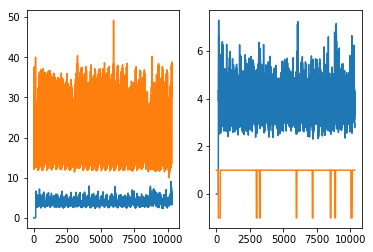

In [8]:
plt.subplot(1,2,1)
plt.plot(codisp.mean(axis=1))
plt.plot(10 + data["passengers"]*0.001)
plt.subplot(1,2,2)
plt.plot(codisp_reser.mean(axis=1))
plt.plot(DATA["labels"])

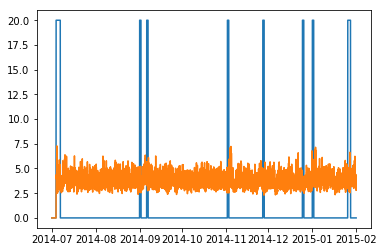

In [22]:
plt.plot(DATA["timestamp"], 10-10*DATA["labels"])
plt.plot(DATA["timestamp"], codisp_reser.mean(axis=1))

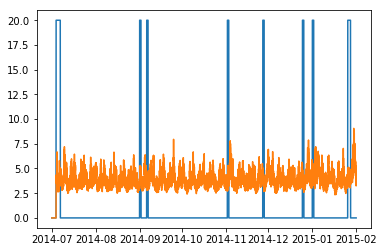

In [21]:
plt.plot(DATA["timestamp"], 10-10*DATA["labels"])
plt.plot(DATA["timestamp"], codisp.mean(axis=1))